## Inspiration
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way.I want to use a dateset from Airbnb to help people make decision when traveling to Seattle.

In [1]:
!pip install category_encoders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
pd.set_option('display.max_columns',None)

In [2]:
cal = pd.read_csv('seattle/calendar.csv')
listing = pd.read_csv('seattle/listings.csv')
reviews = pd.read_csv('seattle/reviews.csv')

## When is the busiest time of the year in Seattle?
### Business Understanding
When we want to travel to a city, the first question come to our mind is when to travel.It is possible to vacation at some of the more expensive resorts if you go in the off-season
### Data Understanding
In the calendar.csv,we can find listing id and the price and availability for that day.
### Prepare Data
1. read data from calendar.csv
2. create month column and group date by month
3. count how many day in a month
4. compute the average number of orders in a month
5. oberseve the distribute of orders


### Data Modeling
no need to modeling
###  Evaluate the Results
I counted the monthly bookings for Seattle,and find that Seattle is very busy in summer. If you want to travel in a more leisure way, you'd better not go to Seattle in summer

/Users/junbo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


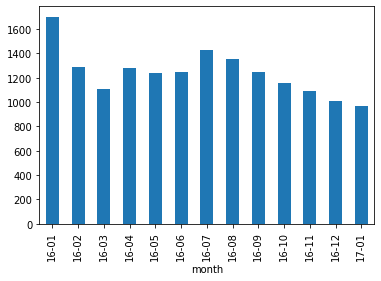

In [3]:
# get all the room which is ordered
ordered = cal[cal['available'] == 'f']

# create month column
ordered['month'] =  ordered['date'].apply(lambda m:m[2:7])

# groupby month, count the num of order for each month
ordered_cnt = ordered.groupby(['month']).count()['listing_id']

# count how many day in a month
date = set(ordered['date'])
df = pd.DataFrame(date)
df['month'] = df[0].apply(lambda m:m[2:7])
days = df.groupby('month').count().loc[:,0]

# compute the average number of orders in a month
avg_cnt = ordered_cnt/days

# oberseve the distribute of orders
avg_cnt.plot(kind='bar')

# There are more orders in summer

## What factors are house prices related to 
### Business Understanding
Travel budget is an important part of travel planning.So i want to know what factors are house prices related to? 
### Data Understanding
In the listings.csv,we can find full descriptions and average review score * Reviews, including unique id for each reviewer and detailed comments.
### Prepare Data
1. Convert the type of price to float,so the linear model can deal with it
2. Drop the rows that 'host_since','bathrooms', 'bedrooms' are missing.Because we can assume these data we don't know,and there are few missing rows
3. Fill bathroom with mean value,so that we can get best performance
4. Reduce the num of category for host_since
5. instant_bookable,host_is_superhost,room_type, is not ordinal or high-cardinality categorical feature.So i choose One-hot encoding for these features
6. neighbourhood_group_cleansed not ordinal but high-cardinality categorical feature.So i try Target encoding,but result is worse.


### Data Modeling
1. split dataset into train and test
2. use train data to train model
3. use test data to test model
4. use model.coef_ to find the most important factor

###  Evaluate the Results
By building a model to predict the house price, I find the most important factor is room type and neighbor.If you wan to reduce your travel budget, you'd better find a house in a cheap neighborhood and share with others.

In [4]:
def clean_and_encode(X):
    '''
    this function clean and encode data, make it more useful for model
    
    Args:
    X : a dataframe with different kinds of features
    
    Return:
    cleaned_X : a cleaned and encoded dataframe
    '''
    cleaned_X = X.copy()
    
    # Convert the type of price to float
    cleaned_X['price'] = cleaned_X['price'].apply(lambda p:float(p[1:].replace(',','')))
    
    # Drop the rows that 'host_since'are missing
    # we can assume these data we don't know,and there are few missing rows
    cleaned_X = cleaned_X.dropna(axis=0,how='any',subset=['host_since','bathrooms','bedrooms'])
    
    # fill'review_scores_rating' with the mode 
    # there are too many missing value,and fill missing with mode, we can get best performance
    cleaned_X['review_scores_rating'] = cleaned_X['review_scores_rating'].fillna(cleaned_X['review_scores_rating'].mode()[0])
    
    # fill'reviews_per_month' with the median 
    # there are too many missing value,and fill missing with median, we can get best performance
    cleaned_X['reviews_per_month'] = cleaned_X['reviews_per_month'].fillna(cleaned_X['reviews_per_month'].median())

    # Reduce the num of category
    cleaned_X['host_since'] = cleaned_X['host_since'].apply(lambda y:pd.to_datetime(y).year)
   
    
    # instant_bookable,host_is_superhost,room_type, is not ordinal or high-cardinality categorical feature -- One-hot encoding
    for col in ['instant_bookable','host_is_superhost','cancellation_policy','room_type','neighbourhood_group_cleansed']:
        cleaned_X = pd.concat([cleaned_X.drop(col,axis=1),pd.get_dummies(cleaned_X[col],prefix=col,drop_first=True)],axis=1)
                
#     # neighbourhood_group_cleansed not ordinal but high-cardinality categorical feature -- Target encoding
#     te = TargetEncoder()
#     te.fit(cleaned_X['neighbourhood_group_cleansed'],cleaned_X['price'])
#     cleaned_X['neighbourhood_group_cleansed'] = te.transform(cleaned_X['neighbourhood_group_cleansed'])
    return cleaned_X

# gather data 
# ['host_since','host_is_superhost','neighbourhood_group_cleansed','room_type','bathrooms','bedrooms','beds','bed_type','availability_365','price']
feats=['reviews_per_month','cancellation_policy','instant_bookable','review_scores_rating','host_since','host_is_superhost','neighbourhood_group_cleansed','room_type','bathrooms','bedrooms','availability_365','accommodates','number_of_reviews','price']
selected_feats = listing[feats]

# clean data 
encoded_feats = clean_and_encode(selected_feats)

# get response vector and feature matrix
y = encoded_feats['price']
X = encoded_feats.drop(['price'],axis=1)



In [5]:
# split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# init model 
model = LinearRegression(normalize=True)
model.fit(X_train,y_train)

# test model
y_pred = model.predict(X_test)
r2_score(y_test,y_pred)
# here are some test i do 
# 0.06079979610998887  'host_since','host_is_superhost','neighbourhood_group_cleansed'
# 0.21902509663269087  + room_type
# 0.42000852499077823  + bathrooms
# 0.5581889558169014   + bedrooms
# 0.564640985289889    + availability_365
# 0.5724880920021433   + accommodates
# 0.5762291040532259   + number_of_reviews(drop)
# 0.5790447571646782   + number_of_reviews(fill_mean)
# 0.5793746137108515   + number_of_reviews(fill_median)
# 0.5799621548345355   + number_of_reviews(fill_mode)
# 0.5805026874471835   + instant_bookable
# 0.5812971274443165   + cancellation_policy
# 0.5845519301098192   + reviews_per_month(fill_mode)
# 0.5849951220666201   + reviews_per_month(fill_median)
# 0.5852417455476389   + reviews_per_month(fill_mean) 
# 0.5793645030598193   + encode neighbourhood_group with target encoding

0.5849951220666201

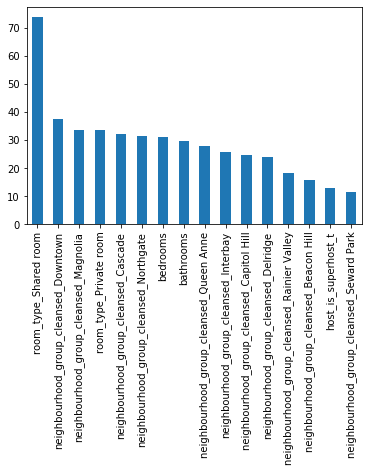

In [6]:
s=pd.Series(abs(model.coef_),index=X.columns)
s = s[s>10]
s.sort_values(ascending=False).plot(kind='bar')

## Where can we find cheap house？
### Business Understanding
Travel budget is an important part of travel planning.So i want to know what factors are house prices related to? 
### Data Understanding
In the listings.csv, we can find price of a house in different group
### Prepare Data
1. group data by nerighborhood
2. plot a bar chart find the most expensive area

###  Evaluate the Results
I group the house by neighbor,and find Magnolia, Queen Anne and Downtown is the most expensive area. So if you want to reduce your travel budget, you should avoid to order a house in these places.

In [7]:
encoded_feats.head()

,reviews_per_month,review_scores_rating,host_since,bathrooms,bedrooms,availability_365,accommodates,number_of_reviews,price,instant_bookable_t,host_is_superhost_t,cancellation_policy_moderate,cancellation_policy_strict,room_type_Private room,room_type_Shared room,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle
0,4.07,95.0,2011,1.0,1.0,346,4,207,85.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1.48,96.0,2013,1.0,1.0,291,4,43,150.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1.15,97.0,2014,4.5,5.0,220,11,20,975.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1.54,100.0,2013,1.0,0.0,143,3,0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.89,92.0,2011,2.0,3.0,365,6,38,450.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


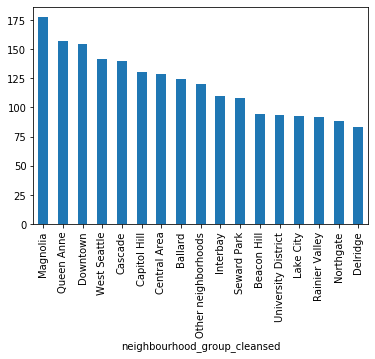

In [8]:
# Compute the average price for each neighbourhood
listing['price'] = listing['price'].apply(lambda p:float(p[1:].replace(',','')))
prices = listing.groupby('neighbourhood_group_cleansed').mean()['price']
prices.sort_values(ascending=False).plot(kind='bar')
# house in MAGNOLIA is most experience